Importing all the packages and functions

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
import os

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
from sklearn import svm
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

np.set_printoptions(precision=4)

import warnings
warnings.filterwarnings('ignore')

# Now assigining all the values into winner_data from df_no_dummies.csv

In [57]:
winner_data = pd.read_csv('data/dummies_removed.csv')

# Removing all the unnecessary columns. 

Now creating a new column "win" inside the same data frame by iterating over the podium column to fill the data inside win column by assigining 1 and 0 based on podium column.

In [58]:

winner_data.drop(columns=['weather_warm','weather_cold', 'weather_dry', 'weather_cloudy', 'weather'], inplace=True)
winner_data['win'] = winner_data['podium'].apply(lambda x: 1 if x==1 else 0)


In [59]:
winner_data.columns

Index(['season', 'round', 'circuit_id', 'weather_wet', 'driver', 'nationality',
       'constructor', 'grid', 'podium', 'driver_points', 'driver_wins',
       'driver_standings_pos', 'constructor_points', 'constructor_wins',
       'constructor_standings_pos', 'qualifying_time', 'driver_age', 'win'],
      dtype='object')

# Renaming the countructors

In [60]:
winner_data.loc[winner_data.constructor == "toro_rosso", "constructor"] = "alphatauri"
winner_data.loc[winner_data.constructor == "renault", "constructor"] = "alpine"
winner_data.loc[winner_data.constructor == "racing_point", "constructor"] = "aston_martin"
winner_data.loc[winner_data.constructor == "force_india", "constructor"] = "aston_martin"

# Creating Test Season

In [61]:
test_season = 2020

# Data Preprocessing to create new list

In [62]:
#https://stackoverflow.com/questions/26347412/drop-multiple-columns-in-pandas#:~:text=You%20don%27t%20need%20to%20wrap%20it%20in%20a,the%20index%20object%20is%20already%20regarded%20as%20list-like.
dropped_constructors = list([x for x in ['constructor_' + str(i) for i in winner_data.constructor.unique()] 
                       if not x in ['constructor_' + str(i) for i in list(winner_data[winner_data['season'] == test_season]['constructor'].unique())] 
                       or 
                       ['constructor_' + str(i) for i in list(winner_data[winner_data['season'] == test_season]['constructor'].unique())].remove(x)])

dropped_drivers = list([x for x in ['driver_' + str(i) for i in winner_data.driver.unique()] 
                       if not x in ['driver_' + str(i) for i in list(winner_data[winner_data['season'] == test_season]['driver'].unique())] 
                       or 
                       ['driver_' + str(i) for i in list(winner_data[winner_data['season'] == test_season]['driver'].unique())].remove(x)])

dropped_circuits = list([x for x in ['circuit_id_' + str(i) for i in winner_data.circuit_id.unique()] 
                        if not x in ['circuit_id_' + str(i) for i in list(winner_data[winner_data['season'] == test_season]['circuit_id'].unique())] 
                        or
                        ['circuit_id_' + str(i) for i in list(winner_data[winner_data['season'] == test_season]['circuit_id'].unique())].remove(x)])

In [63]:
data_in_model = ['season', 'round', 'circuit_id', 'weather_wet', 'driver',
       'constructor', 'grid', 'driver_points', 'driver_wins',
       'driver_standings_pos', 'constructor_points', 'constructor_wins',
       'constructor_standings_pos', 'qualifying_time', 'driver_age', 'win']
winner_data = winner_data[data_in_model]

In [64]:
data = pd.get_dummies(winner_data)

# Finding correlation

In [65]:

corr_data = winner_data[['season', 'round', 'weather_wet', 'grid', 'driver_points', 'driver_wins', 'driver_standings_pos',
       'constructor_points', 'constructor_wins', 'constructor_standings_pos',
       'qualifying_time', 'driver_age', 'win']]

In [66]:
#https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on
corr_matrix = corr_data.corr()
corr_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, season to win
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   season                     13 non-null     float64
 1   round                      13 non-null     float64
 2   weather_wet                13 non-null     float64
 3   grid                       13 non-null     float64
 4   driver_points              13 non-null     float64
 5   driver_wins                13 non-null     float64
 6   driver_standings_pos       13 non-null     float64
 7   constructor_points         13 non-null     float64
 8   constructor_wins           13 non-null     float64
 9   constructor_standings_pos  13 non-null     float64
 10  qualifying_time            13 non-null     float64
 11  driver_age                 13 non-null     float64
 12  win                        13 non-null     float64
dtypes: float64(13)
memory usage: 2.0+ KB


Plotting a heatmap for all the features

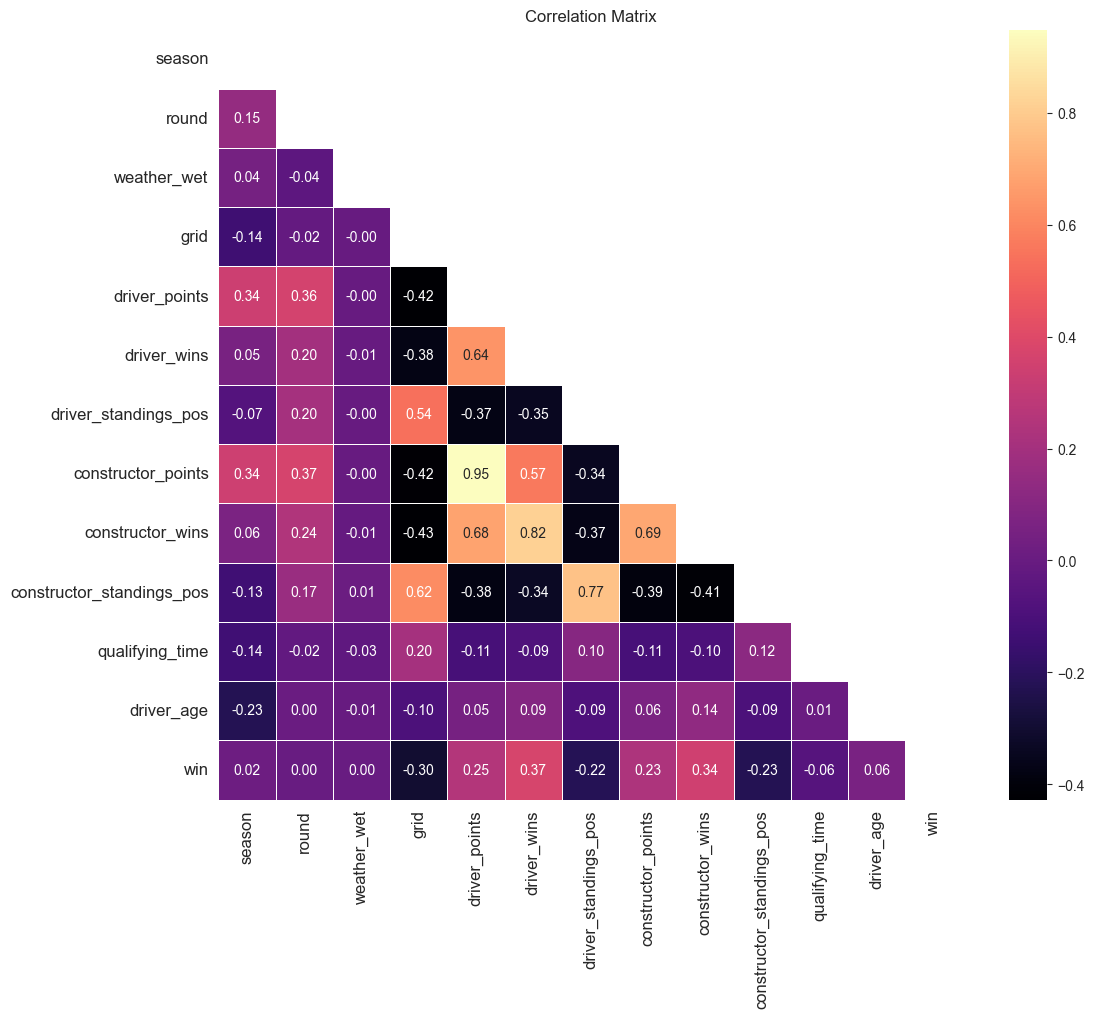

In [67]:
#https://stackoverflow.com/questions/39409866/correlation-heatmap
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='magma', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.savefig('Images\correlation_heat-map.png')
    plt.show()

Plotting Bar Plot for features with respect to Constructor wins

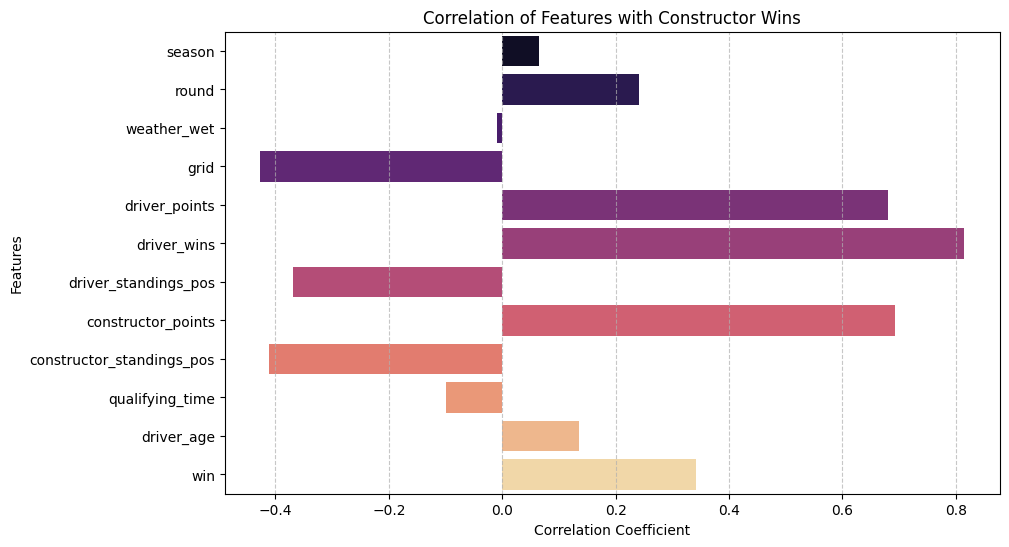

In [68]:
constructor_wins_corr = corr_matrix['constructor_wins'].drop('constructor_wins')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x=constructor_wins_corr.values, y=constructor_wins_corr.index, palette='magma')
plt.title('Correlation of Features with Constructor Wins')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('images/constructor_wins_correlation_plot.png')
plt.show()


Dropping empty columns


In [69]:
data.drop([col for col in dropped_constructors if col in data.columns], inplace=True, axis=1, errors='ignore')
data.drop([col for col in dropped_drivers if col in data.columns], inplace=True, axis=1, errors='ignore')
data.drop([col for col in dropped_circuits if col in data.columns], inplace=True, axis=1, errors='ignore')

In [70]:
print('Total remaining features: ' + str(len(list(data.columns))))

Total remaining features: 58


# Creating Traning and validation sets

In [71]:
#https://rdrr.io/cran/TSstudio/man/train_model.html
train = data[data['season'] < test_season]

X_train = train.drop(columns='win')
y_train = train['win']

scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)

Creating a function to predict points

In [72]:
#https://www.datacamp.com/blog/classification-machine-learning
#https://keras.io/examples/vision/pointnet/
#https://stackoverflow.com/questions/74443144/split-a-point-cloud-las-file-with-classification-values
def point_classification(model, data):
    points = 0
    for race in data[data.season == test_season]['round'].unique():
        
        test = data[(data['season'] == test_season) & (data['round'] == race)]
        X_test = test.drop(['win'], axis = 1)
        y_test = test['win']


        X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

        data_predict = pd.DataFrame(model.predict_proba(X_test), columns = ['proba_0', 'proba_1'])
        data_predict['actual'] = y_test.reset_index(drop = True)
        data_predict.sort_values(by='proba_1', ascending = False, inplace = True)
        data_predict.reset_index(inplace = True, drop = True)
        data_predict['predicted'] = data_predict.index
        data_predict['predicted'] = data_predict.predicted.map(lambda x: 1 if x == 0 else 0)

        points += precision_score(data_predict.actual, data_predict.predicted)

    model_points = points / data[data.season == test_season]['round'].unique().max()
    return model_points

In [73]:
# Assuming df is your DataFrame
numeric_columns = data.select_dtypes(include=['int', 'float']).columns.tolist()
numeric_columns

['season',
 'round',
 'weather_wet',
 'grid',
 'driver_points',
 'driver_wins',
 'driver_standings_pos',
 'constructor_points',
 'constructor_wins',
 'constructor_standings_pos',
 'qualifying_time',
 'driver_age',
 'win']

# Performing Grid Search and Hyperparameter Tuning

In [74]:
#https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
model_result = {'model':[], 'params': [], 'points': []}

In [75]:
#https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv
#https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit
#https://stats.stackexchange.com/questions/622806/how-to-choose-the-potential-hyperparameters-for-gridsearchcv-on-randomforestclas
grid_search={'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None],
        'max_depth': list(np.linspace(5, 55, 26, dtype=int)) + [None]} 

for criterion in grid_search['criterion']:
    for max_features in grid_search['max_features']:
        for max_depth in grid_search['max_depth']:
            model_params = (criterion, max_features, max_depth)
            model = RandomForestClassifier(criterion = criterion, max_features = max_features, max_depth = max_depth, n_jobs=-1)
            model.fit(X_train, y_train)
            
            model_points = point_classification(model, data=data)
            
            model_result['model'].append('random_forest_classifier')
            model_result['params'].append(model_params)
            model_result['points'].append(model_points)

In [76]:

data_result = pd.DataFrame(model_result).sort_values('points', ascending=False).reset_index(drop=True)
data_result.head()

,model,params,points
0,random_forest_classifier,"(gini, sqrt, 5)",0.705882
1,random_forest_classifier,"(entropy, None, 29)",0.705882
2,random_forest_classifier,"(entropy, sqrt, 7)",0.705882
3,random_forest_classifier,"(gini, sqrt, 7)",0.705882
4,random_forest_classifier,"(entropy, log2, 21)",0.705882


Getting results for Grid search

In [53]:
#https://stackoverflow.com/questions/58835592/result-of-gridsearchcv-as-table
prediction_folder = 'Prediction'
if not os.path.exists(prediction_folder):
    os.makedirs(prediction_folder)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

grid_search = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': np.linspace(5, 55, 26, dtype=int).tolist() + [None]
}

rf_model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_model, grid_search, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

print("Random Forest Grid Search Results:")
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

best_rf_model = grid_search.best_estimator_
rf_model_path = os.path.join(prediction_folder, 'best_random_forest_model.pkl')
joblib.dump(best_rf_model, rf_model_path)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Random Forest Grid Search Results:
Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'max_features': None}
Best Accuracy: 0.9569776562951222


['Prediction\\best_random_forest_model.pkl']

In [77]:
best_rf_model_idx = np.argmax(model_result['points'])
best_rf_model = RandomForestClassifier(**dict(zip(['criterion', 'max_features', 'max_depth'], model_result['params'][best_rf_model_idx])), n_jobs=-1)  
best_rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1)

# Generating Classification Report and other results

In [78]:
#https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='win'), data['win'], test_size=0.2, random_state=42)

best_rf_model.fit(X_train, y_train)

y_pred_test = best_rf_model.predict(X_test)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", accuracy_test)

cv_scores = cross_val_score(best_rf_model, X_train, y_train, cv=5)
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

X_test = data[(data['season'] == test_season)].drop(columns='win')
y_test = data[(data['season'] == test_season)]['win']
y_pred_rf = best_rf_model.predict(scaler.transform(X_test))

print("\nBest Random Forest Model - Classification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))


Test Accuracy: 0.957391019337922
Cross-Validation Scores: [0.9558 0.9549 0.9558 0.9549 0.9537]
Mean CV Score: 0.9550109468707397

Best Random Forest Model - Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       280
           1       0.00      0.00      0.00        15

    accuracy                           0.95       295
   macro avg       0.47      0.50      0.49       295
weighted avg       0.90      0.95      0.92       295



In [79]:
accuracy = accuracy_score(y_test, y_pred_rf)
total_correct_predictions = np.trace(confusion_matrix(y_test, y_pred_rf))
total_predictions = len(y_test)
percentage_success = (total_correct_predictions / total_predictions) * 100

print("Results for Random Forest Classifier:")
print("Accuracy Score:", accuracy)
print("Total Correct Predictions:", f"{total_correct_predictions} / {total_predictions}")
print("Percent Success:", f"{percentage_success:.2f}%")


Results for Random Forest Classifier:
Accuracy Score: 0.9491525423728814
Total Correct Predictions: 280 / 295
Percent Success: 94.92%


# Confusion Matrix

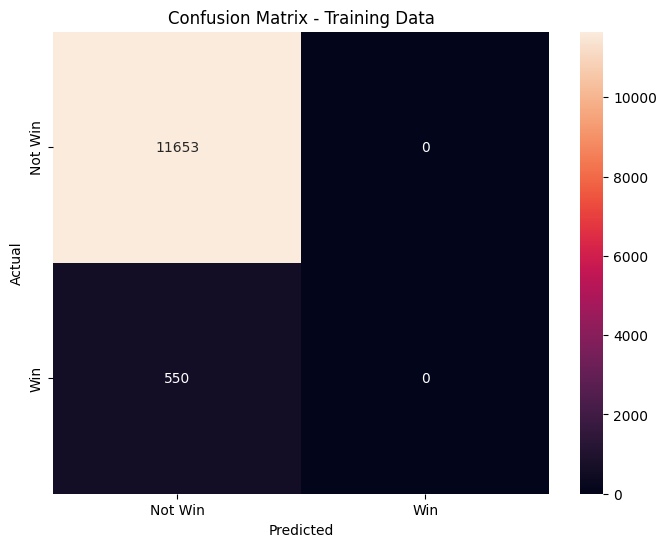

In [80]:
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
X_train_scaled = scaler.transform(X_train)

y_pred_train = best_rf_model.predict(X_train_scaled)

conf_matrix_train = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d',  
            xticklabels=['Not Win', 'Win'], yticklabels=['Not Win', 'Win'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Training Data')
plt.savefig('images/confusion_matrix.png')  # Saving the plot to 'images' directory
plt.show()


# Creating functions for Prediction

In [103]:
#https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
#https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
def get_test_data(data, test_season, race):
    test = data[(data['season'] == test_season) & (data['round'] == race)]
    X_test = test.drop(['win'], axis=1)
    y_test = test['win']
    return X_test, y_test

def to_predictions(model, scaler, X_test):
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    predictions = model.predict_proba(X_test_scaled)
    return predictions

def getting_prediction_data(test_data, y_test, predictions, race):
    predict_data = test_data.copy()
    predict_data = predict_data[(predict_data['season'] == test_season) & (predict_data['round'] == race)]
    predict_data.reset_index(drop=True, inplace=True)
    predict_data['Target'] = y_test
    predict_data['proba_not_win'] = predictions[:, 0] 
    predict_data['proba_win'] = predictions[:, 1]
    predict_data.sort_values(by='proba_win', ascending=False, inplace=True)
    predict_data.reset_index(drop=True, inplace=True)
    predict_data['predicted'] = predict_data.index
    predict_data['predicted'] = predict_data['predicted'].map(lambda x: 1 if x == 0 else 0)
    predict_data['round'] = int(race)
    return predict_data

def predicting(data_result, model, scaler, df, test_season):
    best_params = list(data_result.iloc[0, 1])
    model.fit(X_train, y_train)
    race_predictions = []

    for race in df[df.season == test_season]['round'].unique():
        X_test, y_test = get_test_data(df, test_season, race)
        predictions = to_predictions(model, scaler, X_test)
        predict_data = getting_prediction_data(df, y_test, predictions, race)
        race_predictions.append(predict_data)

    predict_data = pd.concat(race_predictions)
    return predict_data

predict_data = predicting(data_result, model, scaler, data, test_season)


In [104]:
predict_data

,season,round,weather_wet,grid,driver_points,driver_wins,driver_standings_pos,constructor_points,constructor_wins,constructor_standings_pos,...,constructor_ferrari,constructor_haas,constructor_mclaren,constructor_mercedes,constructor_red_bull,constructor_williams,Target,proba_not_win,proba_win,predicted
0,2020,1,0,5,0,0,0,0,0,0,...,False,False,False,True,False,False,NaN,0.66,0.34,1
1,2020,1,0,11,0,0,0,0,0,0,...,True,False,False,False,False,False,NaN,0.71,0.29,0
2,2020,1,0,19,0,0,0,0,0,0,...,False,False,False,False,False,False,NaN,0.71,0.29,0
3,2020,1,0,17,0,0,0,0,0,0,...,False,False,False,False,False,True,NaN,0.71,0.29,0
4,2020,1,0,20,0,0,0,0,0,0,...,False,False,False,False,False,True,NaN,0.71,0.29,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,2020,17,0,14,4,0,17,8,0,8,...,False,False,False,False,False,False,NaN,0.74,0.26,0
16,2020,17,0,5,93,0,8,282,1,2,...,False,False,False,False,True,False,NaN,0.74,0.26,0
17,2020,17,0,1,189,1,3,282,1,2,...,False,False,False,False,True,False,NaN,0.75,0.25,0
18,2020,17,0,6,97,0,7,184,0,4,...,False,False,True,False,False,False,NaN,0.78,0.22,0


Creating functions to handle dummy columns

In [105]:
def drivers_nodummy(df):
    drivers = [item for item in df.columns if 'driver_' in item and item not in ['driver_points', 'driver_wins', 'driver_standings_pos', 'driver_age']]
    drivers_no_dummies = list(df[drivers].idxmax(axis=1))
    df['driver'] = drivers_no_dummies
    df['driver'] = df['driver'].apply(lambda x: x.split('_')[-1])
    return df

def constructors_nodummy(df):
    constructors = [item for item in df.columns if 'constructor_' in item and item not in ['constructor_points', 'constructor_wins', 'constructor_standings_pos']]
    constructors_no_dummies = list(df[constructors].idxmax(axis=1))
    df['constructor'] = constructors_no_dummies
    df['constructor'] = df['constructor'].apply(lambda x: x.replace('constructor_', ''))
    return df

def circuits_nodummy(df):
    circuits = [item for item in df.columns if 'circuit_id_' in item]
    circuits_no_dummies = list(df[circuits].idxmax(axis=1))
    df['circuit'] = circuits_no_dummies
    df['circuit'] = df['circuit'].apply(lambda x: x.replace('circuit_id_', ''))
    return df

def undummify_features(df):
    df = drivers_nodummy(df)
    df = constructors_nodummy(df)
    df = circuits_nodummy(df)
    return df

predict_data = undummify_features(predict_data)

# Final Result

In [106]:
final_result = predict_data[predict_data['predicted'] == 1].sort_values(by='round').reset_index(drop=True)
final_result['driver_won'] = list(predict_data[predict_data['win'] == 1].sort_values(by='round')['driver'])
final_result['constructor_won'] = list(predict_data[predict_data['win'] == 1].sort_values(by='round')['constructor'])
final_result['driver_predicted'] = list(predict_data[predict_data['predicted'] == 1].sort_values(by='round')['driver'])
final_result['constructor_predicted'] = list(predict_data[predict_data['predicted'] == 1].sort_values(by='round')['constructor'])
final_result['driver_on_pole'] = list(predict_data[predict_data['grid'] == 1].sort_values(by='round')['driver'])
final_result['constructor_on_pole'] = list(predict_data[predict_data['grid'] == 1].sort_values(by='round')['constructor'])

final_result = final_result[['season', 'round', 'driver_won', 'constructor_won', 'driver_predicted', 'constructor_predicted']]
final_result.to_csv('data/prediction_final_result_' + str(test_season) + '.csv')
final_result


,season,round,driver_won,constructor_won,driver_predicted,constructor_predicted
0,2020,1,bottas,mercedes,hamilton,mercedes
1,2020,2,hamilton,mercedes,hamilton,mercedes
2,2020,3,hamilton,mercedes,hamilton,mercedes
3,2020,4,hamilton,mercedes,hamilton,mercedes
4,2020,5,verstappen,red_bull,hamilton,mercedes
5,2020,6,hamilton,mercedes,hamilton,mercedes
6,2020,7,hamilton,mercedes,hamilton,mercedes
7,2020,8,gasly,alphatauri,hamilton,mercedes
8,2020,9,hamilton,mercedes,hamilton,mercedes
9,2020,10,bottas,mercedes,hamilton,mercedes
